## Toy implementation of the [Implicit Geometric Regularization for Learning Shapes](https://arxiv.org/abs/2002.10099) paper

[Siren](https://vsitzmann.github.io/siren/)

[Rendering Worlds with Two Triangles](https://www.iquilezles.org/www/material/nvscene2008/rwwtt.pdf)

https://www.iquilezles.org/www/articles/distfunctions/distfunctions.htm

[NeRF](https://www.matthewtancik.com/nerf)

https://dellaert.github.io/NeRF/

In [2]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, clear_output
import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

# tf.debugging.set_log_device_placement(True)

Check GPU usage

In [4]:
# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
# tf.debugging.set_log_device_placement(False)

In [5]:
!pip install trimesh
clear_output()

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a


def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img


def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img


def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)


def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()


def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string


def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))


In [8]:
class VideoWriterWrapper:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

In [9]:
def dist_and_grad(sdf, points):
  with tf.GradientTape() as g:
    g.watch(points)
    dist = sdf(points)
  point_grad = g.gradient(dist, points)
  return dist, point_grad


def compute_loss(sdf, points, bg_point_n=500):
  n, dim = points.shape
  all_points = tf.concat([points, tf.random.uniform([bg_point_n, dim], -2.0, 2.0)], 0)
  dist, grad = dist_and_grad(sdf, all_points)
  surface_loss = tf.reduce_mean(tf.square(dist[:n]))
  offsurface_loss = tf.reduce_mean(tf.exp(-tf.square(dist[n:]/0.02)))
  grad_norm2 = tf.reduce_sum(tf.square(grad), -1)
  grad_loss = tf.reduce_mean(tf.square(grad_norm2-1.0))

  return surface_loss*1e2 + grad_loss + offsurface_loss

In [10]:
def vis_f(sdf, points=None, d=1.5):
  y, x = np.mgrid[-d:d:256j, -d:d:256j]
  coords = np.stack([x, y], -1).astype(np.float32)
  dist = sdf(coords)[...,0]
  f = pl.figure(figsize=(10, 8))
  pl.axis('equal')
  pl.grid()
  pl.contourf(x, y, dist, 16)
  pl.colorbar()
  pl.contour(x, y, dist, levels=[0.0], colors='white')

  if points is not None:
    dist, point_grad = dist_and_grad(sdf, points)
    x, y = points.numpy().T
    u, v = point_grad.numpy().T
    pl.quiver(x, y, u, v, color='white')

  pl.show()

## 3d

In [11]:
import trimesh
mesh = trimesh.load('/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/data/test_task_meshes/1.obj')

In [12]:
mesh.show()

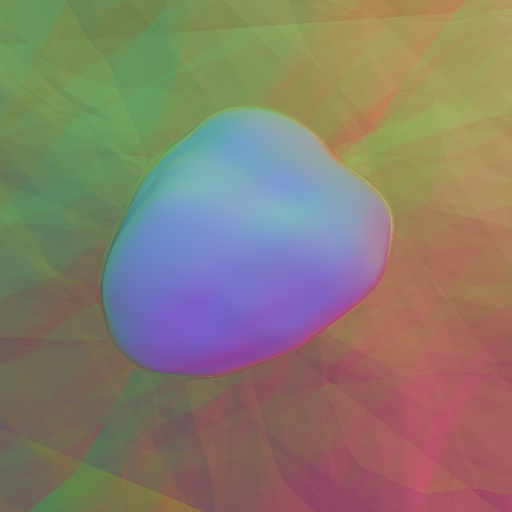

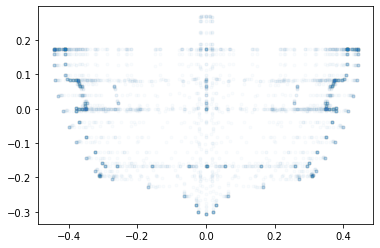

In [13]:
#@title init {vertical-output: true}
sdf = Sequential(
  [Activation(lambda x:x*50.0)] + 
  [Dense(80, tf.nn.swish) for i in range(6)] + 
  [Dense(1,
      kernel_initializer=tf.initializers.constant(1.0/80),
      bias_initializer=tf.initializers.constant(-0.1))]
)

# for visualization
def sdf_slice(xy):
  return sdf(tf.concat([xy, xy[...,:1]*0.0], -1))


@tf.function(experimental_compile=True)
def render(sdf, R, offset, fov=0.7, size=512):
  x = tf.linspace(-fov, fov, size)
  x, y = tf.meshgrid(x, -x)
  rays = tf.stack([x, y, -tf.ones_like(x)], -1)
  rays = tf.nn.l2_normalize(rays, -1) @ R
  pos0 = np.float32([[0, 0, 2.5]]) @ R
  pos = pos0+tf.zeros_like(rays)
  for i in tf.range(40):
    pos += rays*(sdf(pos)-offset)
  dist, normal = dist_and_grad(sdf, pos)

  return normal*0.5+0.5

imshow(render(sdf, tf.eye(3), 0.0))

loss_log = []
# lr0 = 3e-3
lr0 = 1e-3
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [3000, 6000, 8000], [lr0, lr0*0.3, lr0*0.1, lr0*0.03])
trainer = tf.optimizers.Adam(lr)

@tf.function
def train_step(points):
  with tf.GradientTape() as g:
    loss = compute_loss(sdf, points, 2500)
  params = g.watched_variables()
  grads = g.gradient(loss, params)
  trainer.apply_gradients(zip(grads, params))
  return loss

verts = np.float32(mesh.vertices)
verts -= verts.mean(0)
verts /= verts.ptp()*0.4
x, y, z = verts.T
pl.axis('equal')
pl.plot(x, y, '.', alpha=0.02);


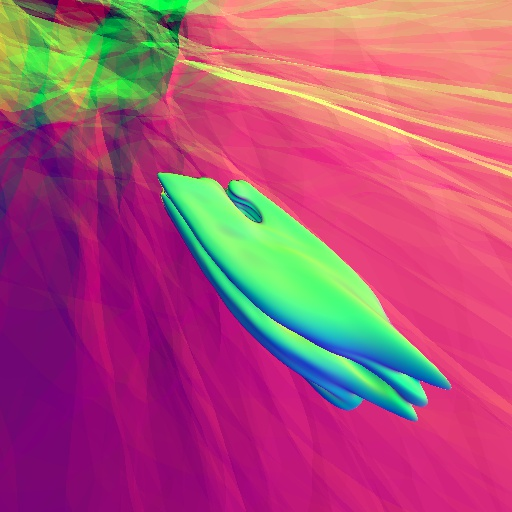

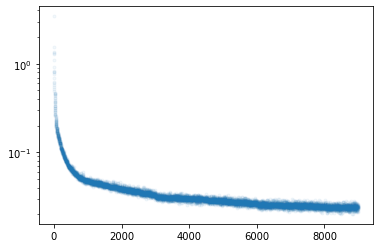

9001 0.021112312


In [14]:
#@title train {vertical-output: true}
for i in range(10_000):
  points = verts[np.random.choice(len(verts), 3000, False)]
  loss = train_step(points)
  loss_log.append(loss.numpy())
  if i>100 and i % 10**int(np.log10(i+1)) == 0:
    clear_output(True)
    R = np.float32(trimesh.transformations.euler_matrix(0.5, 0.5, 0.0)[:3,:3])
    imshow(render(sdf, R, 0.0))
    pl.yscale('log')
    pl.plot(loss_log, '.', alpha=0.05);
    pl.show()
    print(len(loss_log), loss.numpy())


Test SDF

In [19]:
import mesh_to_sdf

points, sdf_val = mesh_to_sdf.sample_sdf_near_surface(mesh, number_of_points = 500_000)

NoSuchDisplayException: ignored

In [ ]:
%%time
with VideoWriterWrapper() as vid:
  ts = np.float32(np.linspace(0, 2*np.pi, 100))
  for t in ts:
    R = trimesh.transformations.euler_matrix(0.5, t, 0.0)[:3,:3].astype(np.float32)
    vid.add(render(sdf, R, 0.0))
    print('\r%.3f'%t, end='')
  for t in ts:
    R = trimesh.transformations.euler_matrix(0.5, t, 0.0)[:3,:3].astype(np.float32)
    vid.add(render(sdf, R, tf.sin(t)*0.3))
    print('\r%.3f'%t, end='')